NACC Import

In [6]:
import pandas as pd
nacc_df = pd.read_parquet('../../../../randy/rfb/raw_data/NACC/investigator_nacc69.parquet', engine = 'fastparquet')

In [7]:
# Select relevant columns for analysis
df = nacc_df.loc[:, ['NACCID', 'NACCADC', 'VISITDAY', 'VISITMO', 'VISITYR', 'NACCACTV',
            'DEMENTED', 'NACCADMD', 'NACCALZD', 'NACCALZP', 'PROBAD', 'PROBADIF', 
            'POSSAD', 'POSSADIF', 'NACCETPR',
            'BIRTHMO', 'BIRTHYR', 'SEX', 'RACE', 'EDUC', 'NACCAGE', 'NACCAGEB', 'NACCAPOE', 'NACCNE4S', 'NACCUDSD',
            'NACCTBI', 'TBI', 'TBIBRIEF', 'TBIWOLOS', 
            'TOBAC30', 'TOBAC100', 'SMOKYRS', 'PACKSPER', 'QUITSMOK',
            'ALCFREQ', 'ALCOHOL', 'ALCABUSE',
            'HYPERT', 'HYPERTEN', 'HXHYPER', 'NACCAHTN', 'NACCHTNC',
            'NACCBMI',
            'NACCDBMD', 'DIABET', 'DIABETES',
            'HEARING', 'HEARAID', 'HEARWAID',
            'DEPD', 'DEPDSEV', 'NACCGDS', 'NACCADEP', 'DEPTREAT', 'DEP2YRS', 'DEPOTHR']]

In [8]:
import pandas as pd
import numpy as np
# Clean TBI (Traumatic Brain Injury) related columns
# Replace unknown (9) and not available (-4) values with NaN
tbi_cols = ['NACCTBI', 'TBI', 'TBIBRIEF', 'TBIWOLOS', 'TOBAC30', 'TOBAC100', 'ALCOHOL',
            'ALCABUSE', 'HYPERTEN', 'DIABET', 'DIABETES', 'HEARING', 'HEARAID', 
            'DEPD', 'DEP2YRS', 'DEPOTHR']
for col in tbi_cols:
    df[col] = df[col].replace({9: np.nan, -4: np.nan})

# Overwrite 8, 9, and -4 as NaN in the PACKSPER column
for col in ['PACKSPER', 'ALCFREQ', 'HEARWAID', 'DEPDSEV']:
    df[col] = df[col].replace({8: np.nan, 9: np.nan, -4: np.nan})

# Overwrite -4 as NaN in the HXHYPER column
for col in ['HXHYPER', 'NACCAHTN', 'NACCHTNC', 'NACCDBMD', 'NACCADEP']:
    df[col] = df[col].replace({-4: np.nan})

# Overwrite 8 and -4 as NaN in the HYPERT column
df['HYPERT'] = df['HYPERT'].replace({8: np.nan, -4: np.nan})
df['DEPTREAT'] = df['DEPTREAT'].replace({8: np.nan, -4: np.nan})

# Overwrite 88, 99, and -4 as NaN in the SMOKYRS column
df['SMOKYRS'] = df['SMOKYRS'].replace({88: np.nan, 99: np.nan, -4: np.nan})

# Clean quit smoking data
df['QUITSMOK'] = df['QUITSMOK'].replace({888: np.nan, 999: np.nan, -4: np.nan})

# Clean BMI data
df['NACCBMI'] = df['NACCBMI'].replace({888.8: np.nan, -4: np.nan})
df['NACCBMI'] = np.where(df['NACCBMI'] > 800, np.nan, df['NACCBMI'])

# Clean depression scale data
df['NACCGDS'] = df['NACCGDS'].replace({88: np.nan, -4: np.nan})

# Clean education data
df['EDUC'] = df['EDUC'].replace({99: np.nan})

# Clean education data
df['RACE'] = df['RACE'].replace({99: np.nan})

# Clean APOE
df['NACCAPOE'] = df['NACCAPOE'].replace({9: np.nan})

In [9]:
df['ad_dx'] = (
                 (df.NACCADMD == 1) | 
                 (df.NACCALZD == 1) | 
                 (df.PROBAD == 1) | 
                 (df.PROBADIF == 1) | 
                 (df.POSSAD == 1) | 
                 (df.POSSADIF == 1)).astype(int)

df['NACCAPOE'] = df['NACCAPOE'].map({1: 'e3/e3', 2: 'e3/e4', 3: 'e2/e3', 4: 'e4/e4', 5: 'e2/e4', 6: 'e2/e2'})
df['RACE'] = df['RACE'].map({1: 'White', 2: 'Black', 3: 'Native American', 4: 'Pacific Islander', 5: 'Asian' })

In [10]:
import sys
sys.path.append('../ukb')  # adjust the path as needed
from doubleml_utils import encode

df = encode(df, col='NACCAPOE', prefix='apoe')
df = encode(df, col = 'RACE', prefix = 'race')

In [11]:
df.to_parquet('NACC_cleaned.parquet', engine = 'fastparquet')

In [27]:
df.shape

Education to AD

In [1]:
import numpy as np
import pandas as pd
from econml.dr import DRLearner
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
import matplotlib.pyplot as plt

import numpy as np
import scipy.sparse


dml_df = df

dml_df = dml_df[dml_df['NACCAGE'] > 65]

# fill na with means
np.int = int  
scipy.sparse.csr.csr_matrix.A = property(lambda self: self.toarray())
scipy.sparse.csc.csc_matrix.A = property(lambda self: self.toarray())

covs = ['NACCAGE', 'SEX'] + [col for col in dml_df.columns if col.startswith('apoe_')]

for col in covs:
    dml_df[f"{col}_x_education_years"] = dml_df[col] * dml_df['EDUC']


X = dml_df.loc[:, covs + [col for col in dml_df.columns if (col.endswith('_x_education_years'))]]

D = dml_df['EDUC']
Y = dml_df['ad_dx']

print(X.isna().sum())
print(Y.isna().sum())

if D.isna().sum() > 0:
    subset_IIDs = D[D.isna()].index
    X = X.loc[~X.index.isin(subset_IIDs)]
    Y = Y.loc[~Y.index.isin(subset_IIDs)]
    D = D.loc[~D.index.isin(subset_IIDs)]


cf = CausalForestDML(model_y=GradientBoostingClassifier(),
                     model_t=GradientBoostingRegressor(),
                     discrete_treatment=False,
                     discrete_outcome=True,
                     cv=5, n_estimators=100,
                     min_samples_leaf=10, max_depth=10,
                     random_state=123)

cf.fit(Y, D, X=X)

# Estimate marginal effects
tau_hat = cf.effect(X, T0=0, T1=1)

# Plot histogram with publication-ready styling
plt.figure(figsize=(8, 6))
plt.hist(tau_hat, bins=50, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
plt.title("Distribution of Estimated Conditional Average Treatment Effects (CATE)\nfor GFAP on Alzheimer's Diagnosis",
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Estimated Treatment Effect (∂Y/∂D)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.axvline(x=np.mean(tau_hat), color='red', linestyle='--', linewidth=2,
           label=f'Mean CATE = {np.mean(tau_hat):.4f}')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

In [ ]:
dml_df['']

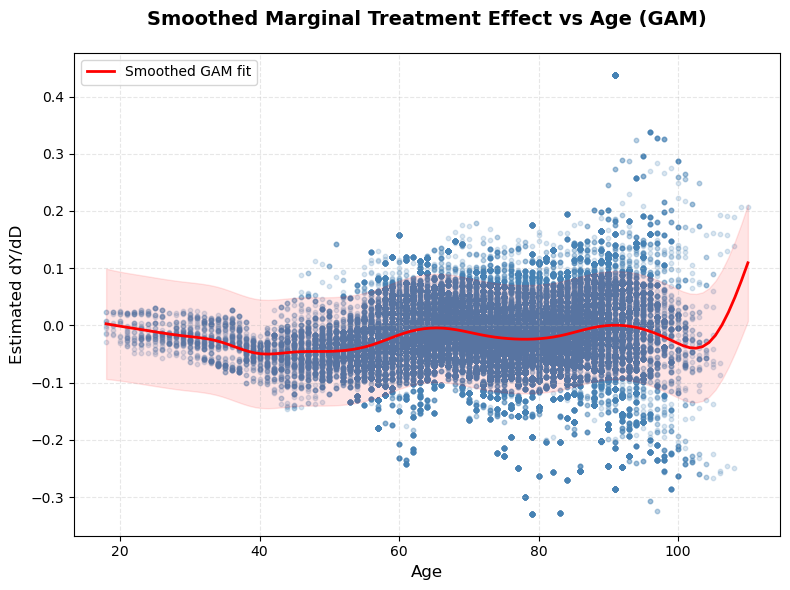

In [ ]:
##################################################################
# plotting age against change in risk
import matplotlib.pyplot as plt

# Estimated CATE (marginal effects)
tau_hat = cf.effect(X)
tau_arr = tau_hat

# Plot tau vs X1
# plt.scatter(X.iloc[:, 2], tau_hat, alpha=0.3)

# Fit GAM
educ_arr = X.iloc[:, 0].to_numpy(dtype=float).reshape(-1, 1)
gam = LinearGAM(s(0)).fit(educ_arr, tau_arr)

# Predict on grid
educ_grid = np.linspace(educ_arr.min(), educ_arr.max(), 100).reshape(-1, 1)
pred = gam.predict(educ_grid)
conf = gam.prediction_intervals(educ_grid, width=0.95)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(educ_arr, tau_arr, alpha=0.2, s=10, color='steelblue')
plt.plot(educ_grid, pred, color='red', lw=2, label='Smoothed GAM fit')
plt.fill_between(educ_grid.ravel(), conf[:, 0], conf[:, 1], color='red', alpha=0.1)

plt.xlabel("Age", fontsize=12)
plt.ylabel("Estimated dY/dD", fontsize=12)
plt.title("Smoothed Marginal Treatment Effect vs Age (GAM)", fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [24]:
X.head()

,NACCAGE,SEX,apoe_e2/e2,apoe_e2/e3,apoe_e2/e4,apoe_e3/e3,apoe_e3/e4,apoe_e4/e4,NACCAGE_x_education_years,SEX_x_education_years,apoe_e2/e2_x_education_years,apoe_e2/e3_x_education_years,apoe_e2/e4_x_education_years,apoe_e3/e3_x_education_years,apoe_e3/e4_x_education_years,apoe_e4/e4_x_education_years
0,70,1,0,0,0,0,1,0,1120.0,16.0,0.0,0.0,0.0,0.0,16.0,0.0
1,71,1,0,0,0,0,1,0,1136.0,16.0,0.0,0.0,0.0,0.0,16.0,0.0
2,66,1,1,0,0,0,0,0,1056.0,16.0,16.0,0.0,0.0,0.0,0.0,0.0
3,63,2,0,0,0,0,0,0,1008.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0
4,80,1,0,0,0,0,0,0,960.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0


(array([0.0000e+00, 2.0000e+01, 1.1800e+02, 1.9500e+02, 3.2400e+02,
        4.0100e+02, 5.8200e+02, 1.3530e+03, 3.5500e+03, 8.1680e+03,
        1.5993e+04, 2.8422e+04, 3.7862e+04, 3.9528e+04, 3.2517e+04,
        2.0180e+04, 8.4750e+03, 2.2700e+03, 3.7300e+02, 2.8000e+01,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00]),
 array([ 10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,
         65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110., 115.,
        120., 125., 130., 135., 140., 145.]),
 <BarContainer object of 27 artists>)

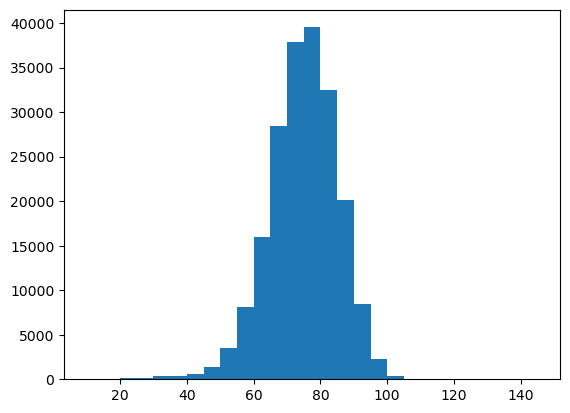

In [ ]:
plt.hist(X.NACCAGE, bins=np.arange(10, 150, 5))

# remove patients under 60, 65

In [ ]:
X['NACCAGE']

In [ ]:
##################################################################
# plotting age against change in risk
import matplotlib.pyplot as plt


# Estimated CATE (marginal effects)
tau_hat = cf.effect(X)
tau_arr = tau_hat

# Plot tau vs X1
# plt.scatter(X.iloc[:, 2], tau_hat, alpha=0.3)

# Fit GAM
educ_arr= X.iloc[:, 0].to_numpy(dtype=float).reshape(-1, 1)

# plot sex curves
sex_arr = X['SEX'].to_numpy()
male_idx = sex_arr == 0
female_idx = sex_arr == 1

# Fit GAM for males
gam_male = LinearGAM(s(0)).fit(educ_arr[male_idx], tau_arr[male_idx])
educ_grid = np.linspace(educ_arr.min(), educ_arr.max(), 100).reshape(-1, 1)
pred_male = gam_male.predict(educ_grid)
conf_male = gam_male.prediction_intervals(educ_grid, width=0.95)

# Fit GAM for females
gam_female = LinearGAM(s(0)).fit(educ_arr[female_idx], tau_arr[female_idx])
pred_female = gam_female.predict(educ_grid)
conf_female = gam_female.prediction_intervals(educ_grid, width=0.95)

# # Predict on grid
# educ_grid = np.linspace(educ_arr.min(), educ_arr.max(), 100).reshape(-1, 1)
# pred = gam.predict(educ_grid)
# conf = gam.prediction_intervals(educ_grid, width=0.95)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(educ_arr, tau_arr, alpha=0.2, s=10, color='steelblue')
plt.plot(educ_grid, pred_male, color='blue', lw=2, label='Smoothed GAM fit (Male)')
plt.fill_between(educ_grid.ravel(), conf_male[:, 0], conf_male[:, 1], color='blue', alpha=0.1)

plt.plot(educ_grid, pred_female, color='red', lw=2, label='Smoothed GAM fit (Female)')
plt.fill_between(educ_grid.ravel(), conf_female[:, 0], conf_female[:, 1], color='red', alpha=0.1)

plt.xlabel("Age", fontsize=12)
plt.ylabel("Estimated dY/dD", fontsize=12)
plt.title("Smoothed Marginal Treatment Effect vs Age (GAM)", fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

ValueError: y data should have at least 1 samples, but found 0

In [21]:
X['SEX'].value_counts()

SEX
2    116493
1     83867
Name: count, dtype: int64

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from IPython.display import display

# Example: turn everything into a DataFrame
#df_features = X.copy()
df_features = X[['NACCAGE', 'SEX', 'apoe_e2/e2', 'apoe_e2/e3', 'apoe_e2/e4', 'apoe_e3/e3', 'apoe_e3/e4', 'apoe_e4/e4']].copy()
df_features["CATE"] = tau_hat
df_features["Age"] = X['NACCAGE']
df_features['SEX'] = X['SEX'] - 1 # check for male or female

# Define high/low groups
n_bins = 10
df_features["CATE_group"] = pd.qcut(df_features["CATE"], q=n_bins, labels=list(range(n_bins)))

# Compare means
group_means = df_features.groupby("CATE_group").mean()
print(group_means)

# Create a more polished version of the table
publication_table = group_means.copy()

# Round the values to appropriate decimal places
publication_table = publication_table.round(3)

# Rename columns to be more descriptive
publication_table = publication_table.rename(columns={
    'NACCAGE': 'Age (years)',
    'SEX': 'Female (%)',
    'EDUC': 'Education\n(years)',
    'apoe_e2/e2': 'APOE ε2\ncarrier (%)',
    'apoe_e3/e3': 'APOE ε3/ε3\n(%)',
    'apoe_e2/e3': 'APOE ε2/ε3\n(%)',
    'apoe_e3/e4': 'APOE ε3/ε4\n(%)',
    'apoe_e2/e4': 'APOE ε2/ε4\n(%)',
    'apoe_e4/e4': 'APOE ε4/ε4\n(%)',
    'CATE': 'Mean CATE'
})

# Convert percentages (multiply by 100 for percentage columns)
percentage_cols = ['Female (%)', 'APOE ε2\ncarrier (%)', 'APOE ε3/ε3\n(%)', 
                   'APOE ε3/ε4\n(%)', 'APOE ε4/ε4\n(%)', 'APOE ε2/ε3\n(%)', 'APOE ε2/ε4\n(%)']
for col in percentage_cols:
    publication_table[col] = (publication_table[col] * 100).round(1)


# Rename index to be more descriptive
publication_table.index = [f'Tertile {i+1}' for i in range(len(publication_table))] 
#['Quintile 1 (Lowest)', 'Quintile 2', 'Quintile 3', 
                          #'Quintile 4', 'Quintile 5 (Highest)']
publication_table.index.name = 'CATE Group'

# Display the formatted table
print("Publication-ready table:")
display(publication_table)



              NACCAGE       SEX  apoe_e2/e2  apoe_e2/e3  apoe_e2/e4  \
CATE_group                                                            
0           75.114887  0.448620    0.001547    0.138095    0.010630   
1           73.977349  0.623310    0.003642    0.133014    0.019558   
2           73.526205  0.643656    0.005790    0.094839    0.030598   
3           73.782665  0.653298    0.004473    0.072511    0.024054   
4           73.172046  0.680114    0.006715    0.078982    0.024607   
5           72.436715  0.589396    0.004285    0.063484    0.025613   
6           74.199970  0.602753    0.002893    0.076067    0.032771   
7           74.926551  0.528880    0.004097    0.058809    0.016638   
8           74.855292  0.513753    0.002242    0.078483    0.025962   
9           77.637511  0.530366    0.001552    0.062735    0.015170   

            apoe_e3/e3  apoe_e3/e4  apoe_e4/e4      CATE        Age  
CATE_group                                                           
0      

/tmp/ipykernel_3109118/301402222.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = df_features.groupby("CATE_group").mean()


,Age (years),Female (%),APOE ε2\ncarrier (%),APOE ε2/ε3\n(%),APOE ε2/ε4\n(%),APOE ε3/ε3\n(%),APOE ε3/ε4\n(%),APOE ε4/ε4\n(%),Mean CATE,Age
CATE Group,,,,,,,,,,
Tertile 1,75.115,44.9,0.2,13.8,1.1,37.2,35.1,8.2,-0.101,75.115
Tertile 2,73.977,62.3,0.4,13.3,2.0,30.9,38.5,5.4,-0.056,73.977
Tertile 3,73.526,64.4,0.6,9.5,3.1,36.3,29.0,3.3,-0.041,73.526
Tertile 4,73.783,65.3,0.4,7.3,2.4,54.7,18.7,2.7,-0.032,73.783
Tertile 5,73.172,68.0,0.7,7.9,2.5,44.7,21.4,3.7,-0.024,73.172
Tertile 6,72.437,58.9,0.4,6.3,2.6,48.8,19.2,4.9,-0.015,72.437
Tertile 7,74.200,60.3,0.3,7.6,3.3,51.7,17.9,6.0,-0.004,74.200
Tertile 8,74.927,52.9,0.4,5.9,1.7,47.0,23.4,5.1,0.008,74.927
Tertile 9,74.855,51.4,0.2,7.8,2.6,39.9,31.3,6.6,0.027,74.855
